In [2]:
# Sagemaker sdk import

import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.sklearn.estimator import SKLearns
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
# version check

sagemaker.__version__

'2.199.0'

### This cell creates an S3 bucket and copies the input dataset to it.

1. Create an S3 bucket called `mlops-tutorials-bucket`
2. Copy the file `heart.csv` to a directory inside the bucket.

*Note: We will use this bucket to store all future data and artifacts*

In [4]:
import os
import boto3

print("boto3 version: ", boto3.__version__)

region = "ap-south-1"
local_file = "heart.csv"
bucket_name = "mlops-tutorials-bucket"
bucket_dir = "data"
s3_file_path = f"input/{local_file}"
data_s3_path = f"s3://{bucket_name}/{bucket_dir}"
print("data_s3_path: ", data_s3_path)
input_data_s3_url = os.path.join(data_s3_path, s3_file_path)
print("input_data_s3_url: ", input_data_s3_url)

s3_client = boto3.client("s3")
# s3_client.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
s3_client.upload_file(local_file, bucket_name, f"{bucket_dir}/{s3_file_path}")

boto3 version:  1.33.9
data_s3_path:  s3://mlops-tutorials-bucket/data
input_data_s3_url:  s3://mlops-tutorials-bucket/data/input/heart.csv


### Create preprocessing script
1. We create a python script which will be used to preprocess the input data and create 3 outputs i.e. for train, test and validation.
2. We are going to use [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) to preprocess our input data
3. SageMaker Processing will<br>
    a. initialize a docker container<br>
    b. copy input data from S3 to the docker container<br>
    c. execute the preprocessing.py script which creates output in the container<br>
    d. finally copy the output datasets from the container  to the specified S3 bucket locations.

*The writefile magic command in Jupyter Notebooks allows you to create a file with the contents written in the same cell*

In [5]:
%%writefile preprocessing.py

# imports
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler


if __name__=='__main__':
    
    # define the input and output dataset paths within the container
    file_name = "heart.csv"
    processing_container_base_path = "/opt/ml/processing"
    processing_container_input_data_path = os.path.join(processing_container_base_path, "input")
    processing_container_train_data_path = os.path.join(processing_container_base_path, "train")
    processing_container_test_data_path = os.path.join(processing_container_base_path, "test")
    processing_container_val_data_path = os.path.join(processing_container_base_path, "val")

    # read the csv into a pandas dataframe
    df = pd.read_csv(os.path.join(processing_container_input_data_path, file_name))
    
    # define the columns to be encoded and scaled
    categorical_columns = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
    numerical_columns = ["age","trtbps","chol","thalachh","oldpeak"]
    
    # one hot encoding of categorical features
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    print('ONE-HOT ENCODING COMPLETED')
        
    # scaling of numerical features
    scaler = RobustScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    print('SCALING COMPLETED')
    
    # SHUFFLE split the input data into 3 parts
    # train 70%
    # validation 20%
    # test 10%    
    train_data, validation_data, test_data = np.split(
        df.sample(frac=1, random_state=1729), [int(0.7 * len(df)), int(0.9 * len(df))],
    )        
    print(f"DATA SPLIT COMPLETED\nTRAIN:{train_data.shape} | VALIDATION:{validation_data.shape} | TEST:{test_data.shape}")
    
    # separate the features and target variable
    X_train = train_data.drop(['output'], axis=1)
    y_train = train_data[['output']]
    X_val = validation_data.drop(['output'], axis=1)
    y_val = validation_data[['output']]
    X_test = test_data.drop(['output'], axis=1)
    y_test = test_data[['output']]    
    print('FEATURES AND TARGETS SEPARATED')

    X_train.to_csv(os.path.join(processing_container_train_data_path, "X_train.csv"), index=False)
    X_val.to_csv(os.path.join(processing_container_val_data_path, "X_val.csv"), index=False)
    X_test.to_csv(os.path.join(processing_container_test_data_path, "X_test.csv"), index=False)

    y_train.to_csv(os.path.join(processing_container_train_data_path, "y_train.csv"), index=False)
    y_val.to_csv(os.path.join(processing_container_val_data_path, "y_val.csv"), index=False)
    y_test.to_csv(os.path.join(processing_container_test_data_path, "y_test.csv"), index=False)
    print('SAVED TRANSFORMED DATA FILES')

Overwriting preprocessing.py


### Initialize Sagemaker role and session which are later used for running the SageMaker Processing Job


In [6]:
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Define output S3 paths for the train, validation and test dataset

In [7]:
train_data_s3_url = os.path.join(data_s3_path, "train")
validation_data_s3_url = os.path.join(data_s3_path, "val")
test_data_s3_url = os.path.join(data_s3_path, "test")

print("train_data_s3_url: ", train_data_s3_url)
print("validation_data_s3_url: ", validation_data_s3_url)
print("test_data_s3_url: ", test_data_s3_url)

train_data_s3_url:  s3://mlops-tutorials-bucket/data/train
validation_data_s3_url:  s3://mlops-tutorials-bucket/data/val
test_data_s3_url:  s3://mlops-tutorials-bucket/data/test


### SageMaker Processing (we use a scikit learn image here for processing which has all the preinstalled libraries like pandas, numpy, scikit-learn, etc):
We use SageMaker Processing by simply providing the preprocessing script and the respective input and output S3 locations to the SageMaker Processing Class. This Class expects input data to be in S3. SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. The underlying infrastructure for a Processing job is fully managed by Amazon SageMaker. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes.

You can specify the scikit-learn framework version, instance type to use in the Processing job as well as the number of instances you want to run for the processing job.


References:
1. [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html)
2. [SKLearnProcessor Documentation](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html)
3. [Supported scikit-learn versions](https://docs.aws.amazon.com/sagemaker/latest/dg/sklearn.html)

In [8]:
# instantiate a Sciki-Learn Processor object
sklearn_processing = SKLearnProcessor(
    framework_version="1.2-1",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=10,
    base_job_name="mlops-processing-job-89",
    role=role
)

# Define input
# source is the S3 path of the heart.csv file 
# destination is the local container path
processing_inputs = [
    ProcessingInput(source=input_data_s3_url, destination="/opt/ml/processing/input")
]

# Define output list
# source is the local container path
# destination is the S3 path of the output file
processing_outputs=[
    ProcessingOutput(
        output_name="train_data",
        source="/opt/ml/processing/train",
        destination=train_data_s3_url
    ),
    ProcessingOutput(
        output_name="val_data",
        source="/opt/ml/processing/val",
        destination=validation_data_s3_url
    ),    
    ProcessingOutput(
        output_name="test_data",
        source="/opt/ml/processing/test",
        destination=test_data_s3_url
    )
]

sklearn_processing.run(
    inputs=processing_inputs,
    outputs=processing_outputs,
    code='preprocessing.py',
    wait=True,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating processing-job with name mlops-processing-job-89-2024-03-24-08-34-20-719


.......................ONE-HOT ENCODING COMPLETED
SCALING COMPLETED
DATA SPLIT COMPLETED
TRAIN:(212, 23) | VALIDATION:(60, 23) | TEST:(31, 23)
FEATURES AND TARGETS SEPARATED
SAVED TRANSFORMED DATA FILES



#### Your AWS `SageMaker >  Processing > Processing Jobs` section should have an `InProgress` processing job as shown in the image below.
Note: After the processing is complete the status will become `Completed`

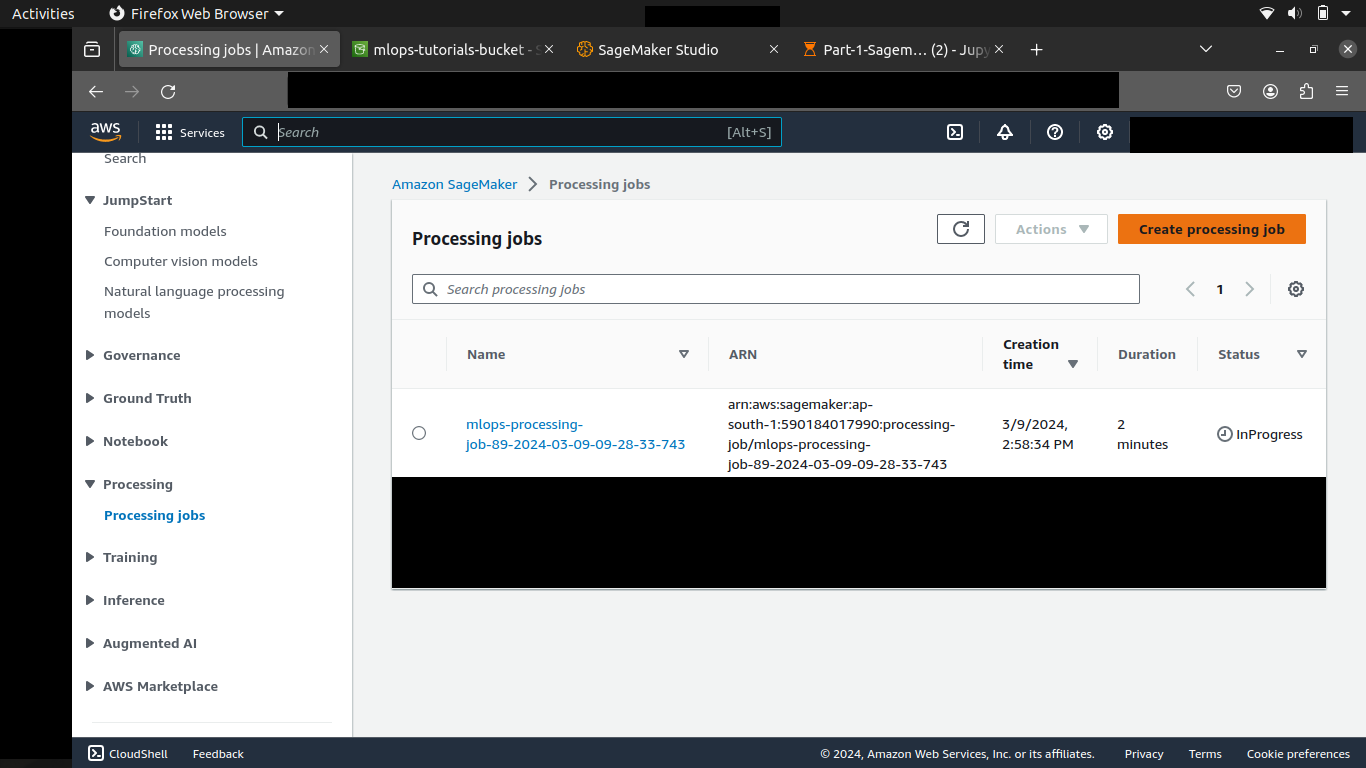

In [9]:
from IPython import display
display.Image("/root/MLOPS/images/SageMaker-Processing-Edit.png")

The processing takes some time to complete. You can view the Processing Jobs in `SageMaker`>`Processing Jobs` in the AWS Console.

You can also view the respective outputs in the S3 directories defined i.e.<br>
- s3://mlops-tutorials-bucket/data/train
- s3://mlops-tutorials-bucket/data/val
- s3://mlops-tutorials-bucket/data/test

### Create a training script
1. We create a python script which will be used to train an SVM classifier model.
2. We are going to use [SageMaker Training](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html) to train the model.
3. SageMaker Training will<br>
    a. initialize a docker container<br>
    b. copy the train data and validation data from S3 to the docker container<br>
    c. execute the train.py script which creates output as model artifacts (files) in the container<br>
    d. finally copy the model artifacts from the container to the specified S3 bucket location.
    
*The writefile magic command in Jupyter Notebooks allows you to create a file with the contents written in the same cell*

In [10]:
%%writefile train.py

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pandas as pd
import argparse
import logging
import joblib
import sys
import os

def parse_args():
    
    # parser initialization
    parser = argparse.ArgumentParser()
    
    # hyperparameters sent by client
    parser.add_argument("--regularization", type=float, default=1.0)
    parser.add_argument("--gamma", type=float, default=1.0)
    parser.add_argument("--kernel", type=str, default='rbf')
    
    return parser.parse_known_args()
    
    
if __name__=='__main__':   
    args, _ = parse_args()
    training_container_train_data_path = os.environ.get('SM_CHANNEL_TRAIN')
    training_container_val_data_path = os.environ.get('SM_CHANNEL_VAL')
    training_container_model_path = os.environ['SM_MODEL_DIR']
    training_container_output_dir_path = os.environ['SM_OUTPUT_DATA_DIR']
    
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(logging.StreamHandler(sys.stdout))
        
    X_train = pd.read_csv(os.path.join(training_container_train_data_path, "X_train.csv"))
    y_train = pd.read_csv(os.path.join(training_container_train_data_path, "y_train.csv"))
    X_val = pd.read_csv(os.path.join(training_container_val_data_path, "X_val.csv"))
    y_val = pd.read_csv(os.path.join(training_container_val_data_path, "y_val.csv"))  
    logger.info(f"DATA LOADED: {training_container_train_data_path}")
    logger.info(f"DATA LOADED: {training_container_val_data_path}")
    
    kernel = args.kernel
    C = args.regularization
    gamma = args.gamma
    
    logger.info(f"Hyperparameters:\nkernel: {kernel}\nC: {C}\ngamma: {gamma}")
    
    classifier = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
    classifier.fit(X_train, y_train)
    logger.info("Training Complete !!!")
    
    y_pred = classifier.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred)
        
    logger.info(f"val_accuracy: {val_accuracy}")
    
    model_path = os.path.join(training_container_model_path, "model.joblib")
    joblib.dump(classifier, model_path)
    print("SAVED TRAINED MODEL")
    

def model_fn(model_dir):
    return joblib.load(os.path.join(model_dir, "model.joblib"))

Overwriting train.py


### Get the s3 locations for train and validation data from the sagemaker processing object

In [11]:
train_s3 = sklearn_processing.latest_job.outputs[0].destination
val_s3= sklearn_processing.latest_job.outputs[1].destination

# This will be the input for the Sagemaker training Job
inputs = {'train':train_s3, 'val': val_s3}
inputs

{'train': 's3://mlops-tutorials-bucket/data/train',
 'val': 's3://mlops-tutorials-bucket/data/val'}

### Define the SkLearn Estimator Object with required parameters

In [12]:
sklearn_estimator = SKLearn(
    base_job_name="mlops-1-training-job",  # the sagemaker training job name
    entry_point="train.py",  # name of the training script 
    framework_version="0.23-1",  # SKLearn framework version
    py_version='py3',  # python version
    role=role,  # sagemaker role
    sagemaker_session=sagemaker_session,  # sagemaker session
    instance_type="ml.m5.xlarge",  # the instance type to use for sagemaker training job
    output_path=f"{data_s3_path}/model/"  # s3 location to store the model artifacts after training is completed
)

### Start Training

In [13]:
# training
sklearn_estimator.fit(inputs)

INFO:sagemaker:Creating training-job with name: mlops-1-training-job-2024-03-24-08-38-43-559


Using provided s3_resource
2024-03-24 08:38:43 Starting - Starting the training job...
2024-03-24 08:38:58 Starting - Preparing the instances for training...
2024-03-24 08:39:42 Downloading - Downloading input data...
2024-03-24 08:40:02 Downloading - Downloading the training image...
2024-03-24 08:40:43 Training - Training image download completed. Training in progress.
2024-03-24 08:40:43 Uploading - Uploading generated training model2024-03-24 08:40:33,958 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-03-24 08:40:33,962 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-24 08:40:34,010 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-03-24 08:40:34,159 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-24 08:40:34,172 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-24 08:40:34,185 sage

#### Your AWS `SageMaker > Training > Training Jobs` section should have an `InProgress` training job as shown in the image below.
Note: After the training is complete the status will become `Completed`. This means that the model has been trained successfully and is now ready for deployment i.e. you can create an endpoint for the trained model so that it can be used for inference.

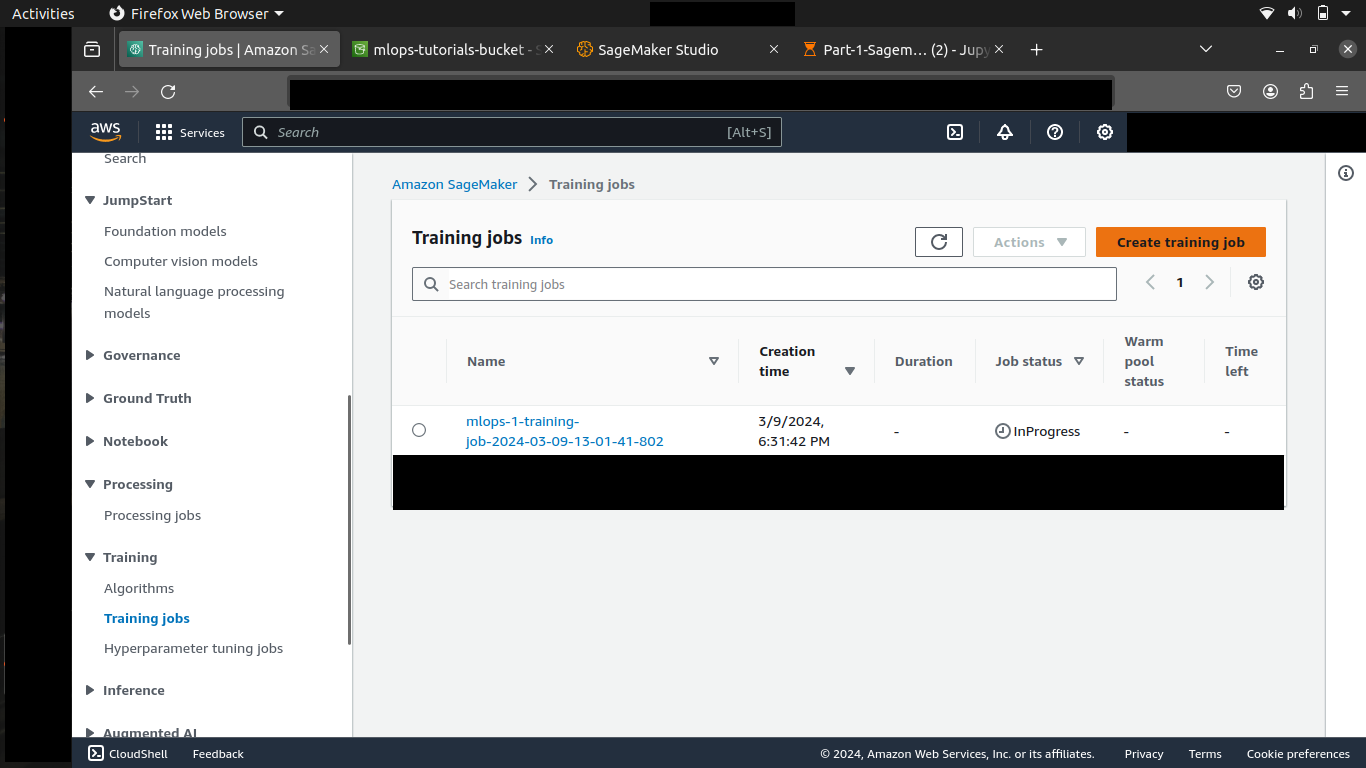

In [14]:
from IPython import display
display.Image("/root/MLOPS/images/SageMaker-Training-Edit.png")

### Deploy the Model as a SageMaker endpoint

We use a single instance of type `ml.c5.large` to host the model and create an endpoint

In [15]:
# deploy trained model

predictor = sklearn_estimator.deploy(instance_type="ml.c5.large", initial_instance_count=1)

INFO:sagemaker:Creating model with name: mlops-1-training-job-2024-03-24-08-41-47-465
INFO:sagemaker:Creating endpoint-config with name mlops-1-training-job-2024-03-24-08-41-47-465
INFO:sagemaker:Creating endpoint with name mlops-1-training-job-2024-03-24-08-41-47-465


-----!

#### Your AWS `SageMaker > Inference > Endpoints` section should have a new Model Endpoint with the status as `Creating` as shown in the image below.
Note: 
- Once the model endpoint is created the status will change to `InService`
- You will also see the respective entries in the `SageMaker > Inference > Models` and `SageMaker > Inference > Endpoint Configurations` section each.

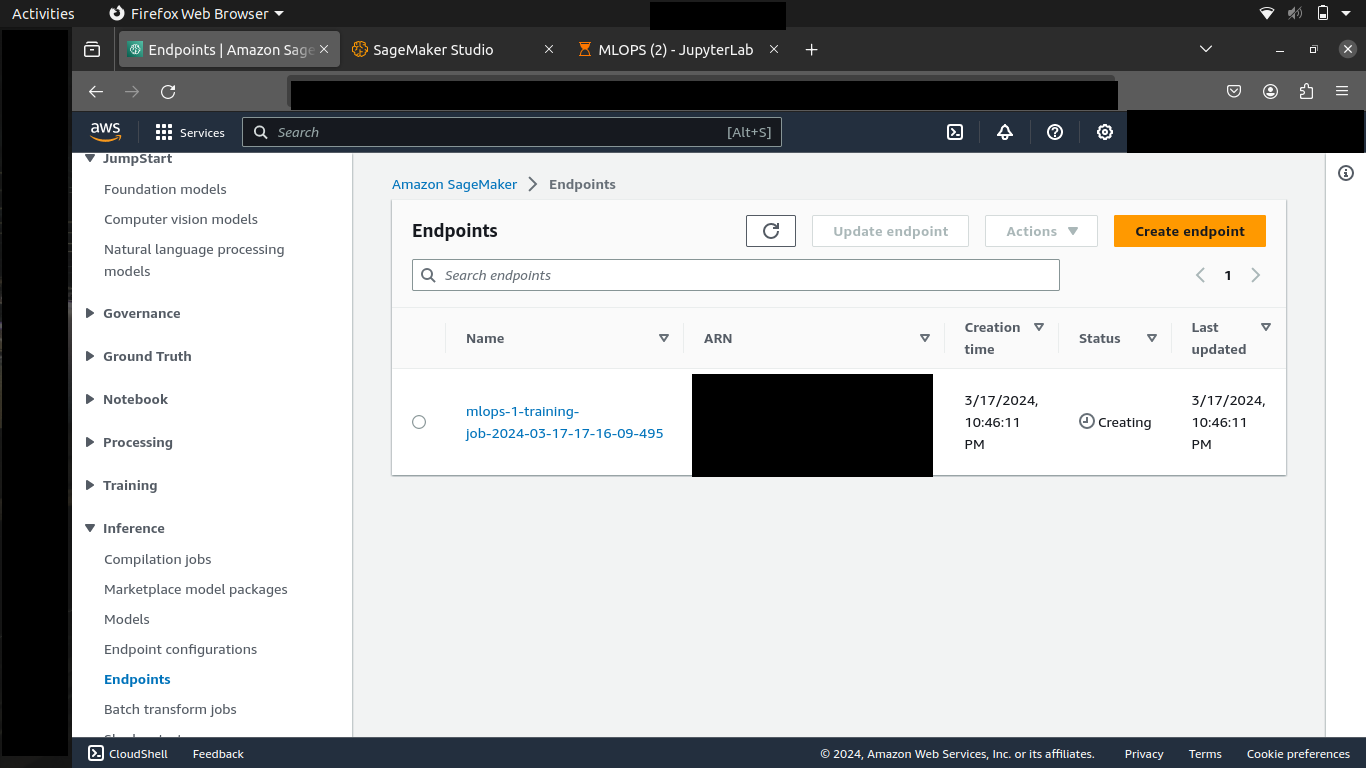

In [16]:
from IPython import display
display.Image("/root/MLOPS/images/Model-Endpoint-Edit.png")

### Predictions on Test Dataset
Let's do some sample predictions on the test dataset using the endpoint we just created for our trained model.

In [17]:
# sample predictions
import pandas as pd
X_test_path = "s3://mlops-tutorials-bucket/data/test/X_test.csv"
y_test_path = "s3://mlops-tutorials-bucket/data/test/y_test.csv"
x_test = pd.read_csv(X_test_path)
predictor.predict(x_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1])

### Conclusion

- We used a dataset from our S3 bucket location and did some processing on it using SageMaker Processing Job
- We trained a simple SVM Algorithm to train a ML model on the train dataset using SageMaker Training Job
- We Deployed the Model as an Endpoint
- We finally dis some inference to predict whether the patients in the dataset are at a risk of Heart disease or not.